In [1]:
from jax import config
config.update("jax_enable_x64", True)

import jax
import jax.numpy as jnp

In [2]:
arr=jnp.array([1.])
print(arr.devices())
print(arr.dtype)

{cuda(id=0)}
float64


In [3]:
pip install -q git+https://github.com/ott-jax/ott@main



[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [5]:
t = np.load("t.npz")
t3=np.load("t3.npz")
result_t_analytic = t["t1"]
result_t_implicit = t["t2"]
t6400 = t3["t1"]

In [8]:
result_t_analytic = np.vstack((result_t_analytic,t6400 ))


In [10]:
np.savez('t.npz', t1=result_t_analytic, t2=result_t_implicit, n_span = [10, 20, 30, 40, 80, 120, 180, 270, 400, 800, 1600,3200,5000,6400])

In [4]:
import matplotlib

import numpy as np
import time
import timeit
from jax.example_libraries import optimizers as jax_opt


import matplotlib.pyplot as plt
import mpl_toolkits.axes_grid1


import ott
from ott.geometry import pointcloud
from ott.problems.linear import linear_problem
from ott.solvers.linear import sinkhorn

from sklearn.datasets import make_blobs


import warnings
warnings.filterwarnings("ignore")


In [5]:

@jax.jit
def dCdx(x, y):
  # if sqEuclidean
  # each row calculates dC_k/dx_k

  #return 2*(x-y.transpose())
  return 2 * (x[:, None, :] - y[None, :, :]) # M X N X d

@jax.jit
def dOTdx(ot):
  x = ot.geom.x
  y = ot.geom.y
  dCk_dxk =  dCdx(x,y)
  P = ot.matrix
  grad = jnp.sum(dCk_dxk * P[:,:,None], axis=1)
  return grad # M X d




@jax.jit
def LHS_matrix(ot): #
  a = ot.a # size of M
  b = ot.b # size of N
  P = ot.matrix # M by N
  a_P = jnp.sum(P, axis=1)
  b_P = jnp.sum(P, axis=0)

  a_diag = jnp.diag(a_P)  # N by N
  b_diag = jnp.diag(b_P)  # M by M
  PT     = jnp.transpose(P)

  H1 = jnp.concatenate([a_diag, P], axis = 1) # M by (M+N)
  H2 = jnp.concatenate([PT, b_diag], axis = 1) # N by (M+N)
  H = jnp.concatenate([H1, H2], axis=0) # (M+N) by (M+N)

  return H




@jax.jit
def d2Cdx2(x, y):
  # if sqEuclidean
  # the second derivative is 2
  return 2


@jax.jit
def RHS(ot):
  x = ot.geom.x
  y = ot.geom.y
  dCk_dxk =  dCdx(x,y)
  P = ot.matrix
  b_g = jnp.transpose(dCk_dxk * P[:,:,None], [1,0,2]) # N by M by d

  b_g_col = jnp.sum(b_g, axis=0) # M by D

  M, D = b_g_col.shape
  b_f  = jnp.zeros((M, M, D))
  indices = (jnp.arange(M), jnp.arange(M))
  b_f = b_f.at[indices[0], indices[1], :].set(b_g_col) # M by M by d

  b = jnp.concatenate([b_f, b_g], axis=0) # (M+N) X M X d
  return b

@jax.jit
def Sinkhorn_Hessian(ot):
  epsilon = ot.geom.epsilon
  H = LHS_matrix(ot)
  R = RHS(ot)

  eigenvalues, eigenvectors = jnp.linalg.eigh(H)
  eigenvalues_sqrt_inv = jnp.where(eigenvalues>1e-7, 1/jnp.sqrt(eigenvalues), 0)
  Hsqrt = eigenvectors * eigenvalues_sqrt_inv[jnp.newaxis, :] # (M+N) by r


  bHsqrt  = jnp.einsum('ikd, is ->ksd ', R, Hsqrt)  #
  Hessian_1 = jnp.einsum('ksd, jst->kdjt', bHsqrt, bHsqrt)/epsilon

  # second part
  x = ot.geom.x
  y = ot.geom.y
  P = ot.matrix
  dCk_dxk = dCdx(x, y)   # M by N by D
  d2Ck_dx2k= d2Cdx2(x, y)
  M, N, D = dCk_dxk.shape

  weighted_C = - dCk_dxk/epsilon * P[:, :, None]
  Hessian_2_part = jnp.einsum('kjs,kjt->kst', weighted_C, dCk_dxk) # M-by-D-by-D
  Hessian_2 = jnp.zeros((M, D, M, D))
  for k in range(M):
    for s in range(D):
      for t in range(D):
        Hessian_2 = Hessian_2.at[k, s, k, t].set(Hessian_2_part[k, s, t])


  # third part
  Hessian_3_diag = jnp.sum(d2Ck_dx2k*P,axis=1)
  Hessian_3 = jnp.zeros((M, D, M, D))
  for k in range(M):
    for s in range(D):
      Hessian_3 = Hessian_3.at[k, s, k, s].set(Hessian_3_diag[k])

  Hessian = Hessian_1 + Hessian_2 + Hessian_3

  return Hessian

@jax.jit
def sample_bolb(n, d_X, d_Y, blob_std, noise, seed):
  np.random.seed(seed)
  x, data_mem  = make_blobs(n_samples=n, n_features=d_X, centers=len(blob_std), cluster_std=blob_std)
  mu           = np.ones((n,)) / n
  nv           = np.ones((n,)) / n
  w            = np.random.normal(size=[d_X,d_Y])
  w_int        = w + 1*np.random.normal(size=[d_X,d_Y])

  y            = x.dot(w) + noise*np.random.normal(size=[n,d_Y])
  index        = np.random.permutation(n)
  y_permute    = y[index, :]
  y_pred       = x.dot(w_int)

  y_jx         = jnp.array(y_permute)
  pred_jx      = jnp.array(y_pred)
  w_int_jx     = jnp.array(w_int)
  x_jx         = jnp.array(x)
  w_jx         = jnp.array(w)

  return mu, nv, pred_jx, y_jx, w_int_jx, x_jx, w_jx  


def sample_points(n, dim):
    #rng, *rngs = jax.random.split(rng, 5)
    x = np.random.uniform(size=(n, dim))
    y = np.random.uniform(size=(n, dim))
    a = np.random.uniform(size=(n,)) + 0.1
    b = np.random.uniform(size=(n,)) + 0.1
    a = a / np.sum(a) # marginal dist, need to be uniform for spectrum study
    b = b / np.sum(b)

    a_jx = jnp.array(a)
    b_jx = jnp.array(b)
    x_jx = jnp.array(x)
    y_jx = jnp.array(y)


    return a_jx, b_jx, x_jx, y_jx


In [6]:
from ott.solvers.linear import implicit_differentiation as imp_diff


@jax.jit
def solve_ott( x, y, mu, nv, 𝜀, threshold):
    geom = pointcloud.PointCloud(x, y, epsilon=𝜀)
    prob = linear_problem.LinearProblem(geom, a=mu, b=nv)

    solver = sinkhorn.Sinkhorn(
        threshold=threshold, use_danskin=False,
    )
    out = solver(prob)
    return out

@jax.jit
def loss_implicit(x, y,mu,nv, 𝜀, threshold):
    geom = pointcloud.PointCloud(x, y, epsilon=𝜀)
    prob = linear_problem.LinearProblem(geom, a=mu, b=nv)

    solver = sinkhorn.Sinkhorn(
        threshold=threshold, use_danskin=False, implicit_diff=imp_diff.ImplicitDiff()
    )
    out = solver(prob)
    return out.reg_ot_cost

@jax.jit
def loss_unroll(x, y,mu,nv, 𝜀, threshold):
    geom = pointcloud.PointCloud(x, y, epsilon=𝜀)
    prob = linear_problem.LinearProblem(geom, a=mu, b=nv)

    solver = sinkhorn.Sinkhorn(
        threshold=threshold,  use_danskin=False, implicit_diff=None
    )
    out = solver(prob)

    return out.reg_ot_cost

@jax.jit
def hess_loss_analytic(x, y, mu, nv,  𝜀, threshold):
    OT                 = solve_ott( x, y, mu, nv, 𝜀, threshold)
    hess_analytic      = Sinkhorn_Hessian(OT)
    return hess_analytic


@jax.jit 
def hess_loss_implicit(x,y,mu,nv, 𝜀, threshold):
  return jax.hessian(loss_implicit,  argnums=0)(x, y,mu,nv, 𝜀, threshold) 


@jax.jit 
def hess_loss_unroll(x,y,mu,nv, 𝜀, threshold):
  return jax.hessian(loss_unroll,  argnums=0)(x, y,mu,nv, 𝜀, threshold) 



In [7]:

methods = ( "Implicit","Analytic(ours)")
dim     = 2
n_span       = [10, 20, 30, 40, 80, 120, 180, 270, 400, 800]
epsilon_span = [5e-3, 5e-2,  5e-1]



In [ ]:

print("----Testing different epsilon, n and methods to calculate Hessian---")
K = 10
result_t_analytic = np.ones((len(n_span), len(epsilon_span), K)) * np.nan
result_t_implicit = np.ones((len(n_span), len(epsilon_span), K)) * np.nan
error_i_a         = np.ones((len(n_span), len(epsilon_span), K)) * np.nan

for k in range(K):

  print("----Round %s---"%(k))

  for i, n in enumerate(n_span):

      print()
      #rng = jax.random.PRNGKey(i)
      mu, nv, x, y = sample_points(n, dim)
      epsilon_base = pointcloud.PointCloud(x, y).mean_cost_matrix
      # Set a threshold that scales with n
      threshold_n = 0.05 / (n**0.33)
      hess_analytic = lambda 𝜀: hess_loss_analytic( x, y,mu,nv,𝜀,threshold_n)
      hess_implicit = lambda 𝜀: hess_loss_implicit(x, y, mu,nv, 𝜀, threshold_n)


      for j, 𝜀_scale in enumerate(epsilon_span):
                    𝜀 =  𝜀_scale * epsilon_base                 
                    print("n:",n,", 𝜀_scale:", 𝜀_scale, f", 𝜀: {𝜀:.5f}", f", thr.: {threshold_n:.5f}",end=" |",)
                    timeit_res = %timeit -o  hess_analytic(𝜀).block_until_ready()
                    result_t_analytic[i,j,k] = timeit_res.average



                    try:  
                          timeit_res = %timeit -o  hess_implicit(𝜀).block_until_ready()
                          result_t_implicit[i,j,k]   = timeit_res.average

                    except RuntimeError:
                          print("\n-------- Method: Implicit failed XXX" )
                          pass

                    print()



np.savez('t.npz', t1=result_t_analytic, t2=result_t_implicit)




In [ ]:
n_span       = [1600, 3200,5000, 6400]
epsilon_span = [5e-3, 5e-2,  5e-1]



print("----Testing different epsilon, n and methods to calculate Hessian---")
K = 10
result_t_analytic2 = np.ones((len(n_span), len(epsilon_span), K)) * np.nan

for k in range(K):

    print("----Round %s---"%(k))
    for i, n in enumerate(n_span):

        mu, nv, x, y = sample_points(n, dim)
        epsilon_base = pointcloud.PointCloud(x, y).mean_cost_matrix
        threshold_n = 0.01 / (n**0.33)
        #hess_analytic = lambda 𝜀: hess_loss_analytic( x, y,mu,nv,𝜀,threshold_n)

        for j, 𝜀_scale in enumerate(epsilon_span):
                      𝜀 = epsilon_base * 𝜀_scale
                      print("n:",n,", 𝜀_scale:", 𝜀_scale, f", 𝜀: {𝜀:.5f}", f", thr.: {threshold_n:.5f}",end=" |",)
                      timeit_res = %timeit -o  hess_loss_analytic( x, y,mu,nv,𝜀,threshold_n).block_until_ready()
                      result_t_analytic2[i,j,k] = timeit_res.average





np.savez('t3.npz', t1=result_t_analytic2)



In [ ]:
result_t_analytic = np.vstack((result_t_analytic, result_t_analytic2))
np.savez('t.npz', t1=result_t_analytic, t2=result_t_implicit)


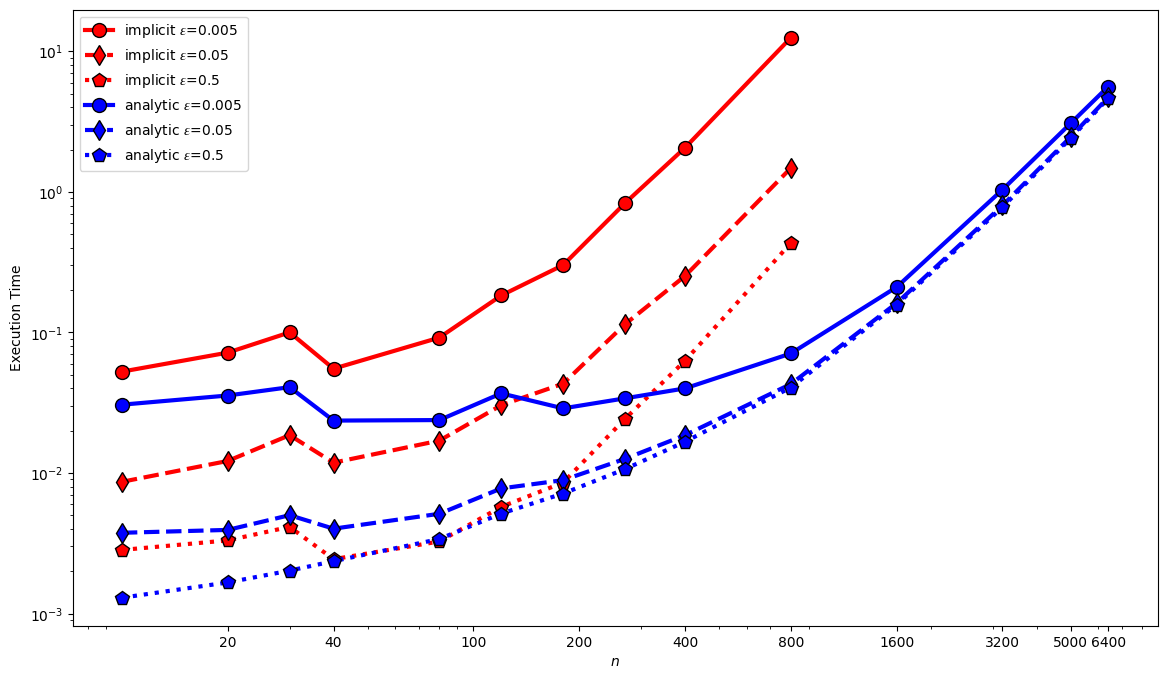

In [14]:
list_legend = []
fig, ax = plt.subplots(figsize=(14, 8))

n_span       = [10, 20, 30, 40, 80, 120, 180, 270, 400, 800, 1600]

ax.plot(n_span, np.nanmean(result_t_implicit[:len(n_span),0,:],axis=1),marker = "o", color="red",  markersize=10, linestyle="-",
        markeredgecolor="k",
        lw=3,label="implicit $𝜀$=0.005" )

ax.plot(n_span, np.nanmean(result_t_implicit[:len(n_span),1,:],axis=1),marker = "d", color="red",  markersize=10, linestyle="--",
        markeredgecolor="k",
        lw=3,label="implicit $𝜀$=0.05" )
ax.plot(n_span, np.nanmean(result_t_implicit[:len(n_span),2,:],axis=1),marker = "p", color="red",  markersize=10, linestyle=":",
        markeredgecolor="k",
        lw=3,label="implicit $𝜀$=0.5" )


n_span       = [10, 20, 30, 40, 80, 120, 180, 270, 400, 800, 1600, 3200, 5000,6400]
ax.plot(n_span, np.nanmean(result_t_analytic[:len(n_span),0,:],axis=1),marker = "o", color="blue",  markersize=10,
        markeredgecolor="k",
        lw=3,label="analytic $𝜀$=0.005" )

ax.plot(n_span, np.nanmean(result_t_analytic[:len(n_span),1,:],axis=1),marker = "d", color="blue",  markersize=10, linestyle="--",
        markeredgecolor="k",
        lw=3,label="analytic $𝜀$=0.05" )
ax.plot(n_span, np.nanmean(result_t_analytic[:len(n_span),2,:],axis=1),marker = "p", color="blue",  markersize=10, linestyle=":",
        markeredgecolor="k",
        lw=3,label="analytic $𝜀$=0.5" )


ax.set_yscale("log")
ax.set_xscale("log")
plt.xlabel("$n$")
#plt.xticks(ticks=np.arange(len(n_span)), labels=n_span)
ax.set_xticks([20, 40, 100, 200, 400, 800, 1600, 3200, 5000,6400])
ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
plt.ylabel("Execution Time")
ax.legend()
plt.show()
